In [50]:
import cuquantum as cu
import cutensor as ct

from qiskit import *
from qiskit.converters import circuit_to_dag
from qiskit.quantum_info import Operator
from qiskit.circuit.library.standard_gates import CPhaseGate, PhaseGate
from qiskit.circuit.library import QFT
from qiskit.visualization import array_to_latex

import tensornetwork as tn

import numpy as np

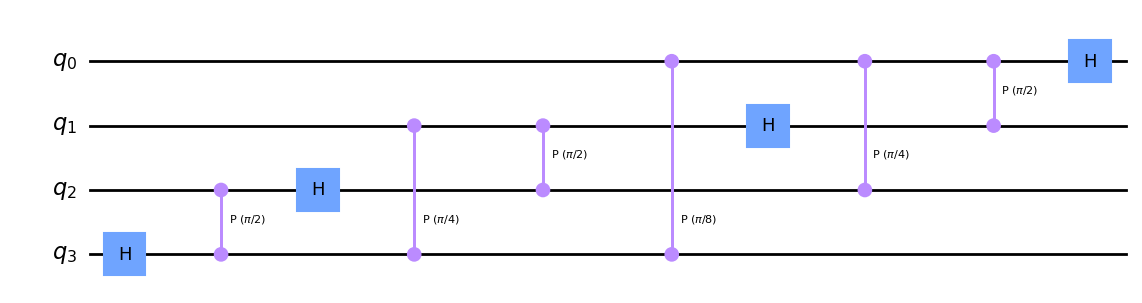

In [26]:
qft_circ = QFT(4, 0, False).decompose()
qft_circ.draw(output="mpl")

In [28]:
for circ_instruction in qft_circ.data:
    gate = circ_instruction[0]
    print(Operator(gate).data)

[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
[[1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 6.123234e-17+1.j]]
[[ 0.70710678+0.j  0.70710678+0.j]
 [ 0.70710678+0.j -0.70710678+0.j]]
[[1.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         1.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.70710678+0.70710678j]]
[[1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j]
 [0

# H Tensor Node

In [29]:
def H_Node(): 
    h_arr = np.array([[1, 1], [1, -1]], dtype=complex) / np.sqrt(2)
    return tn.Node(h_arr, backend="jax")

In [61]:
def CP_Node(theta):
    p_mat = CPhaseGate(theta).to_matrix().reshape((2,2,2,2))
    return tn.Node(p_mat, f"P({theta:0.2f})", backend="jax")

In [ ]:
def P_Node(theta):
    p_mat = PhaseGate(theta).to_matrix().reshape((2,2))
    return tn.Node(p_mat, backend="jax")

In [49]:
start_state = tn.Node(np.array([1.0 + 0.0j, 0.0 + 0.0j]), backend="jax")
hadamard = H_Node()


# Connect our state to the H gate
start_state[0] ^ hadamard[0]

c = tn.contract_between(start_state, hadamard)
print(c.tensor)

[0.70710677+0.j 0.70710677+0.j]


# Multiple Qubits

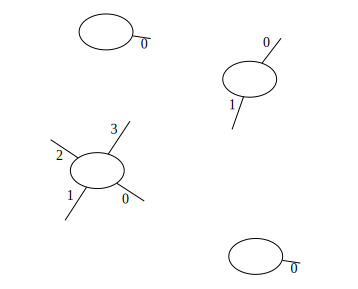

In [43]:
def CNOT_Node():
    cnot_arr = np.array(
        [[1, 0, 0, 0], 
         [0, 1, 0, 0], 
         [0, 0, 0, 1], 
         [0, 0, 1, 0]]
    ).reshape((2,2,2,2))

    return tn.Node(cnot_arr, backend="jax")

def apply_gate(qubit_edges, gate, operating_qubits):
    op = tn.Node(gate, backend="jax")
    for i, bit in enumerate(operating_qubits):
        qubit_edges[bit] ^ op[i]
        qubit_edges[bit] = op[i + len(operating_qubits)]

H = H_Node()
CNOT = CNOT_Node()
all_nodes = []

# Create a set of nodes for our qubits
with tn.NodeCollection(all_nodes):
    state_nodes = [
        tn.Node(np.array([1.0 + 0.0j, 0.0 + 0.0j]), backend="jax") for _ in range(2)
    ]

    qubits = [node[0] for node in state_nodes]
    apply_gate(qubits, H, [0])
    apply_gate(qubits, CNOT, [0, 1])


result = tn.contractors.optimal(all_nodes, output_edge_order=qubits)
tn.to_graphviz(all_nodes, None)
# print(result.tensor)

# Starting on MPO

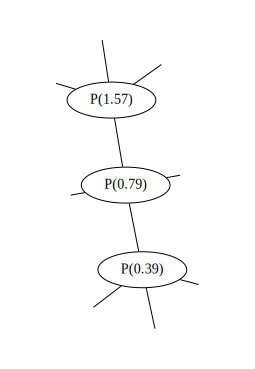

In [66]:
P0 = CP_Node(np.pi/2)
P1 = CP_Node(np.pi/4)
P2 = CP_Node(np.pi/8)
nodes = [P0, P1, P2]

P0[1] ^ P1[1]
P1[3] ^ P2[1]


tn.to_graphviz(nodes, None)